In [3]:
!nvidia-smi -L


GPU 0: NVIDIA RTX A4000 (UUID: GPU-f77e46b5-1ef6-709d-cdf8-ec2267a24e12)


In [1]:
import os
import csv
import pickle
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Jason's file path
root_path = "notebooks/data"

In [3]:
!pwd

/notebooks/notebooks


In [4]:
%cd ..

/notebooks


In [5]:
!ls notebooks/data

2017_fake_followers_tweets.csv
2017_spam1_tweets.csv
TSNE_analysis.png
VAE_model_batch16_epo2_721.h5
VAE_model_sentiment_0801_400k_fake_train.h5
VAE_model_sentiment_726.h5
VAE_model_sentiment_731.h5
VAE_model_sentiment_731_tfidf.h5
all_tweets_df.pkl
fake_embeddings_combined_400k.npy
fake_embeddings_test.npy
fake_tweets_df.pkl
genuine_embeddings_combined_400k.npy
genuine_tweets.csv
genuine_tweets_df.pkl
pca_analysis.png
sentiment140_train.csv
sentiment_classfier_30percent_model
test_combine_embeddings_no_sentiment.npy
test_fake_df_text_embedding_sentiments.npy
test_fake_df_text_embeddings_no_sentiment.npy
test_fake_df_text_embeddings_sentiments.pkl
test_genuine_df_text_embedding_sentiments.npy
test_genuine_df_text_embedding_sentiments.pkl
tfidf_embeddings_test_fake.npy
tfidf_embeddings_test_genuine.npy
tfidf_embeddings_train_fake.npy
tfidf_embeddings_train_genuine.npy
train_fake_df_all_731.pkl
train_fake_df_text_embedding_sentiments.npy
train_fake_df_text_embedding_sentiments.pkl
train_

In [7]:
# Genuine Data Read in
try:
    df_genuine_data = pd.read_csv(f'{root_path}/genuine_embeddings_combined_400k.csv',
                                           usecols=[1],
                                           encoding = 'latin_1',
                                           skiprows=[210607]
                                           )
    print("Data loaded successfully with 'latin_1' encoding.")
except Exception as e:
    print("Error while reading the CSV file:", e)

Error while reading the CSV file: [Errno 2] No such file or directory: 'notebooks/data/genuine_embeddings_combined_400k.csv'


In [52]:
df_genuine_data.shape

(210606, 1)

In [54]:
df_genuine_data.tail()

,text
210601,Photo: i will surely miss august especially th...
210602,@Pape__Chulo what are you trying to say lol
210603,i will surely miss august especially those hol...
210604,andami ko gusto gawin after exams. sana matulo...
210605,@Pape__Chulo my brother saw me as a monster


In [7]:
# Read fake data
fake_data_file =['2017_fake_followers_tweets.csv', '2017_spam1_tweets.csv']

df_fake_combined = pd.DataFrame()
common_columns = None

# Load the fake data
for file in fake_data_file:
    try:
        df = pd.read_csv(f'{root_path}/{file}',
                         encoding = 'latin_1',
                         index_col=False,
                         error_bad_lines=False)

        if df_fake_combined.empty:
            # This is the first file - initialize df_combined and common_columns
            df_fake_combined = df
            common_columns = set(df.columns)
        else:
            # This is a subsequent file - update common_columns and append only common columns to df_combined
            common_columns &= set(df.columns)
            df_fake_combined = pd.concat([df_fake_combined, df[list(common_columns)]])

        print(f"{file} loaded successfully with 'latin_1' encoding.")
    except Exception as e:
        print(f"Error while reading the {file} CSV file:", e)

/tmp/ipykernel_814/3590585392.py:10: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv(f'{root_path}/{file}',
/tmp/ipykernel_814/3590585392.py:10: DtypeWarning: Columns (8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'{root_path}/{file}',
/tmp/ipykernel_814/3590585392.py:10: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv(f'{root_path}/{file}',


2017_fake_followers_tweets.csv loaded successfully with 'latin_1' encoding.
2017_spam1_tweets.csv loaded successfully with 'latin_1' encoding.


In [8]:
from sklearn.model_selection import train_test_split
# Train_fake_df will be used to train VAE to get baseline model
train_fake_df, test_fake_df = train_test_split(df_fake_combined, test_size=0.2, random_state=726)
train_genuine_df, test_genuine_df = train_test_split(df_genuine_data, test_size=0.2, random_state=726)

In [9]:
train_fake_df.columns = train_fake_df.columns.str.replace('"', '')
test_fake_df.columns = test_fake_df.columns.str.replace('"', '')
train_genuine_df.columns = train_genuine_df.columns.str.replace('"', '')
test_genuine_df.columns = test_genuine_df.columns.str.replace('"', '')


In [10]:
train_fake_df_text = train_fake_df[['text']]
test_fake_df_text = test_fake_df[['text']]
train_genuine_df_text = train_genuine_df
test_genuine_df_text = test_genuine_df

In [11]:
train_fake_df_text.shape, test_fake_df_text.shape, train_genuine_df_text.shape, test_genuine_df_text.shape

((272896, 1), (68225, 1), (168484, 1), (42122, 1))

## Fine-Tuning Using Sentiment Analysis


In [12]:
!pip install -q transformers

In [13]:
import torch
import numpy as np
import tqdm
from transformers import DistilBertModel, DistilBertTokenizer
from transformers import DistilBertForSequenceClassification, AdamW

In [19]:
# sentiment140_train_data = pd.read_csv(f'{root_path}/sentiment140_train.csv', encoding = 'latin_1')

In [26]:
# sentiment140_train_data.columns

Index(['0', '1467810369', 'Mon Apr 06 22:19:45 PDT 2009', 'NO_QUERY',
       '_TheSpecialOne_',
       '@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D'],
      dtype='object')

In [27]:
sentiment140_train_data = pd.read_csv(f'{root_path}/sentiment140_train.csv', encoding = 'latin_1', names=["labels", "ids", "date", "flag", "user", "text"])

In [29]:
sentiment140_train_data.head()

,labels,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [14]:
class SentimentClassifier:
    def __init__(self, model_name='distilbert-base-uncased', batch_size=64):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = DistilBertForSequenceClassification.from_pretrained(model_name)
        self.model = self.model.to(self.device)
        self.tokenizer = DistilBertTokenizer.from_pretrained(model_name)
        self.batch_size = batch_size

    def train(self, text, labels, epochs=1, learning_rate=2e-5):
        optimizer = AdamW(self.model.parameters(), lr=learning_rate)
        text = np.array(text)
        labels = np.array(labels)
        
        for epoch in range(epochs):
            num_batches = len(text) // self.batch_size
            for batch_idx in tqdm(range(num_batches), desc=f"Epoch {epoch+1}"):
                batch_texts = text[batch_idx*self.batch_size:(batch_idx+1)*self.batch_size]
                batch_labels = labels[batch_idx*self.batch_size:(batch_idx+1)*self.batch_size]
                # print(f"Type of batch_texts: {type(batch_texts)}")
                # print(f"First few elements of batch_texts: {batch_texts[:5]}")
                inputs = self.tokenizer(batch_texts.tolist(), return_tensors='pt', padding=True, truncation=True)
                inputs = {name: tensor.to(self.device) for name, tensor in inputs.items()}
                outputs = self.model(**inputs, labels=torch.tensor(batch_labels).to(self.device))
                loss = outputs.loss
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

    def predict(self, text):
        inputs = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True)
        inputs = {name: tensor.to(self.device) for name, tensor in inputs.items()}
        with torch.no_grad():
            outputs = self.model(**inputs)
        return outputs.logits


### Labels Description

<p> 0=negative </br> 4=positve</p>

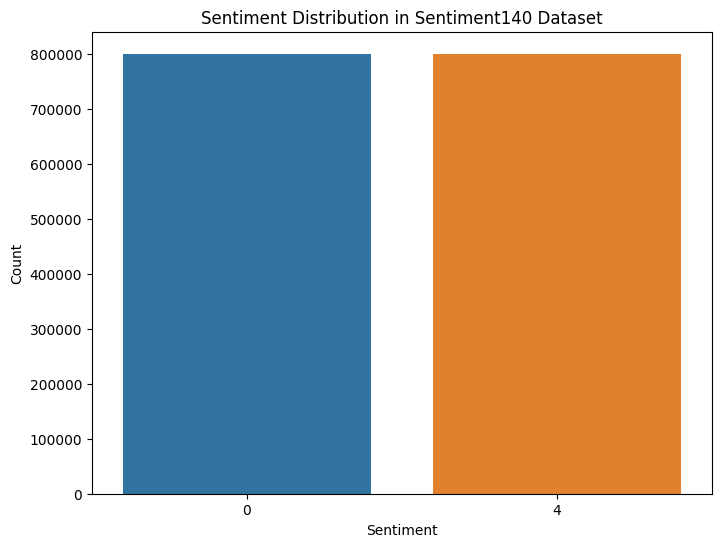

In [33]:
# Visualize the distribution of sentiments
plt.figure(figsize=(8,6))
sns.countplot(x='labels', data=sentiment140_train_data)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution in Sentiment140 Dataset')
plt.show()

In [34]:
# Split train, test sets
senti_train_df, senti_test_df = train_test_split(sentiment140_train_data, test_size=0.2, random_state=726)  # 80% for training, 20% for testing

In [15]:
sentiment_classifier = SentimentClassifier(batch_size=128)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifi

In [80]:
senti_train_labels = (senti_train_df['labels'] / 4).astype(int).tolist()
senti_test_labels = (senti_test_df['labels'] / 4).astype(int).tolist()

In [81]:
# Conver labels to conventional formats 0 = negative, 1 = positive
senti_train_labels

[0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,


In [49]:
type(senti_train_df['text'].iloc[0])

str

In [82]:
senti_train_texts = senti_train_df['text'].apply(str)
senti_test_texts = senti_test_df['text'].apply(str)

In [83]:
## Downsize the training data
down_size_factor = 0.3

data_size = int(0.3 * len(senti_train_texts))

# Extract 30% of the data
senti_train_texts = senti_train_texts[:data_size]
senti_train_labels = senti_train_labels[:data_size]
senti_test_texts = senti_test_texts[:data_size]
senti_test_labels = senti_test_labels[:data_size]

/tmp/ipykernel_112/2383189764.py:7: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  senti_train_texts = senti_train_texts[:data_size]
/tmp/ipykernel_112/2383189764.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  senti_test_texts = senti_test_texts[:data_size]


In [85]:
sentiment_classfier.train(senti_train_texts.tolist(), senti_train_labels, epochs=2)

Epoch 2: 100%|██████████| 3000/3000 [13:59<00:00,  3.57it/s]


In [86]:
model_path = f"{root_path}/sentiment_classfier_30percent_model"
sentiment_classifier.model.save_pretrained(model_path)

In [16]:
model_path = f"{root_path}/sentiment_classfier_30percent_model"
sentiment_classifier.model = DistilBertForSequenceClassification.from_pretrained(model_path)

### DistilBERT with Sentiment Analysis Pre-Trained


In [25]:
class DistilBERT:
    def __init__(self, batch_size=32):
        """ Initialize Distil-BERT model """
        self.model_name = 'distilbert-base-uncased'
        self.model_class = DistilBertModel
        self.tokenizer_class = DistilBertTokenizer

        self.tokenizer = self.tokenizer_class.from_pretrained(self.model_name)
        self.model = self.model_class.from_pretrained(self.model_name)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = self.model.to(self.device)

        self.batch_size=batch_size

    def embed_with_sentiment(self, samples, sentiment_classifier):
        n = len(samples)
        features = []
        sentiment_scores = []

        for i in range(0, n, self.batch_size):
            batch = samples[i:i+self.batch_size]
            encoded_input = self.tokenizer(batch, padding=True, truncation=True, return_tensors='pt')
            encoded_input = {key: value.to(self.device) for key, value in encoded_input.items()}

            with torch.no_grad():
                last_hidden_states = self.model(**encoded_input)

            batch_features = last_hidden_states.last_hidden_state[:, 0, :].cpu().numpy()
            features.extend(batch_features)
            
            # Predict sentiment and convert to probabilities
            batch_sentiment_scores = sentiment_classifier.predict(batch)
            batch_sentiment_scores = torch.softmax(batch_sentiment_scores, dim=1).cpu().numpy()
            sentiment_scores.extend(batch_sentiment_scores)
            
        # Combine original features with sentiment scores
        combined_features = np.hstack([np.array(features), np.array(sentiment_scores)])

        return combined_features


In [15]:
# class DistilBERT:
#     def __init__(self, batch_size=32):
#         """ Initialize Distil-BERT model """
#         self.model_name = 'distilbert-base-uncased'
#         self.model_class = DistilBertModel
#         self.tokenizer_class = DistilBertTokenizer

#         self.tokenizer = self.tokenizer_class.from_pretrained(self.model_name)
#         self.model = self.model_class.from_pretrained(self.model_name)
#         self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#         self.model = self.model.to(self.device)

#         self.batch_size=batch_size

#     def embed(self, samples):
#         n = len(samples)
#         features = []

#         for i in range(0, n, self.batch_size):
#             batch = samples[i:i+self.batch_size]
#             encoded_input = self.tokenizer(batch, padding=True, truncation=True, return_tensors='pt')
#             encoded_input = {key: value.to(self.device) for key, value in encoded_input.items()}

#             with torch.no_grad():
#                 last_hidden_states = self.model(**encoded_input)

#             batch_features = last_hidden_states.last_hidden_state[:, 0, :].cpu().numpy()
#             features.extend(batch_features)

#         return np.array(features)

In [26]:
distil_bert = DistilBERT(batch_size=512)
print("Success!") if distil_bert else print("Fail!")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Success!


In [28]:
sentiment_classifier.model.to(distil_bert.device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [22]:
# tqdm library is used to display the process bar (1s interval), easy to track the process when running in backgroud,
tqdm.pandas(mininterval=1)

AttributeError: type object 'tqdm' has no attribute 'tqdm'

In [23]:
train_fake_df_text.shape, test_fake_df_text.shape, train_genuine_df_text.shape, test_genuine_df_text.shape

((272896, 1), (68225, 1), (168484, 1), (42122, 1))

In [19]:
# train_combine = pd.concat([train_fake_df_text, train_genuine_df_text])

In [20]:
# Shuffle the data
train_combine = train_combine.sample(frac=1, random_state=721)

In [21]:
train_combine.head()

,text
117291,72 This site got me 200 followers quick using ...
51482,\u201cThe unreal is more powerful than the rea...
78228,http://twitpic.com/tl3ln - aquela melhor *-*
174917,@JASMINEVILLEGAS do you reply to the simple h...
71416,"Ð, ÑÐ»ÐµÐºÑÑÐ¾Ð½Ð½Ð°Ñ Ð¿ÑÐ¾Ð¼ÑÑÐ»ÐµÐ½Ð..."


In [22]:
test_combine = pd.concat([test_fake_df_text, test_genuine_df_text])

In [30]:
# Function to process texts in batch
def process_texts(data, distil_bert):
    embeddings = []
    data = data['text'].astype(str).tolist()  # Convert the Series to a list
    for i in tqdm(range(0, len(data), distil_bert.batch_size), total=int(len(data) / distil_bert.batch_size), desc='Processing'):
        batch_texts = data[i:i+distil_bert.batch_size]
        batch_embedding = distil_bert.embed_with_sentiment(batch_texts, sentiment_classifier)
        embeddings.append(batch_embedding)
    return np.concatenate(embeddings)

# train_combine_embeddings = process_texts(train_combine, distil_bert)
# test_combine_embeddings = process_texts(test_combine, distil_bert)
train_fake_df_text_embeddings = process_texts(train_fake_df_text, distil_bert)
train_genuine_df_text_embeddings = process_texts(train_genuine_df_text, distil_bert)
test_fake_df_text_embeddings = process_texts(test_fake_df_text, distil_bert)
test_genuine_df_text_embeddings = process_texts(test_genuine_df_text, distil_bert)

# np.save(f'{root_path}/train_combine_embeddings.npy', train_combine_embeddings)
# np.save(f'{root_path}/test_combine_embeddings.npy', test_combine_embeddings)
np.save(f'{root_path}/train_fake_df_text_embedding_sentiments.npy', train_fake_df_text_embeddings)
np.save(f'{root_path}/train_genuine_df_text_embedding_sentiments.npy', train_genuine_df_text_embeddings)
np.save(f'{root_path}/test_fake_df_text_embeddings_sentiments.npy', test_fake_df_text_embeddings)
np.save(f'{root_path}/test_genuine_df_text_embedding_sentiments.npy', test_genuine_df_text_embeddings)

Processing: 330it [16:42,  3.04s/it]                         
Processing: 134it [05:49,  2.61s/it]                         
Processing: 83it [04:10,  3.02s/it]                        


In [ ]:
# chunk_size = 50000 
# num_chunks = len(data_training_text_only_full) // chunk_size + 1

# def process_texts(data, distil_bert):
#     embeddings = []
#     data = data['text'].tolist()  # Convert the Series to a list
#     for i in tqdm.tqdm(range(0, len(data), distil_bert.batch_size), total=int(len(data) / distil_bert.batch_size), desc='Processing'):
#         batch_texts = data[i:i+distil_bert.batch_size]
#         batch_embedding = distil_bert.embed(batch_texts)
#         embeddings.append(batch_embedding)
#     return np.concatenate(embeddings)

# for i in range(num_chunks):
#     start_index = i * chunk_size
#     end_index = min((i + 1) * chunk_size, len(data_training_text_only_full))
#     data_chunk = data_training_text_only_full[start_index:end_index]

#     # Define the path where you want to save the numpy array
#     npy_path = f'{root_path}/Autoencoder/data_training_text_embeddings_chunk_{i}.npy'

#     # Check if this chunk has already been processed and saved
#     if os.path.exists(npy_path):
#         print(f'Chunk {i} has already been processed.')
#     else:
#         # Process this chunk of data
#         data_chunk_embeddings = process_texts(data_chunk, distil_bert)

#         # Save the processed data as a numpy array
#         np.save(npy_path, data_chunk_embeddings)


### 400k fake/Genuine embeddings 2015/2017

In [6]:
genuine_embeddings_combined_400k = np.load(f'{root_path}/genuine_embeddings_combined_400k.npy')
fake_embeddings_combined_400k = np.load(f'{root_path}/fake_embeddings_combined_400k.npy')

genuine_embeddings_combined_400k.shape, fake_embeddings_combined_400k.shape

((399321, 768), (395987, 768))

In [7]:
genuine_embeddings_combined_400k.shape, fake_embeddings_combined_400k.shape

((399321, 768), (395987, 768))

### Autoencoder impl

In [7]:
from tensorflow.keras.layers import Input, Conv2D, ReLU, LeakyReLU, BatchNormalization, \
     Flatten, Dense, Reshape, Conv2DTranspose, Activation, Lambda, Dropout
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse
from tensorflow.python.framework.ops import disable_eager_execution
import numpy as np

In [8]:
class KLDivergenceLayer(tf.keras.layers.Layer):
    """ Layer to add KL divergence to the model loss. """
    def __init__(self, *args, **kwargs):
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):
        mu, log_variance = inputs
        kl_loss = -0.5 * K.mean(K.sum(1 + log_variance - K.square(mu) - K.exp(log_variance), axis=-1))
        self.add_loss(kl_loss)
        return inputs

class VAE_:
    """ VAE represents a Deep Variational Autoencoder architecture with mirrored encoder and decoder components. """
    def __init__(self, input_shape, intermediate_dim, latent_space_dim, dropout_rate=0.3):
        self.input_shape = input_shape  # (768,)
        self.intermediate_dim = intermediate_dim  # e.g., 256
        self.latent_space_dim = latent_space_dim  # e.g., 2
        self.dropout_rate = dropout_rate

        self.encoder = None
        self.decoder = None
        self.model = None

        self._build()

    def _build(self):
        self._build_encoder()
        self._build_decoder()
        self._build_autoencoder()

    def _build_encoder(self):
        encoder_input = Input(shape=self.input_shape, name="encoder_input")
        x = Dense(self.intermediate_dim, activation='relu')(encoder_input)
        x = BatchNormalization()(x)
        x = Dropout(self.dropout_rate)(x)
        # x = Dense(self.intermediate_dim // 2, activation='relu')(x)  # Additional layer
        # x = BatchNormalization()(x)
        # x = Dropout(self.dropout_rate)(x)

        mu = Dense(self.latent_space_dim, name="mu")(x)
        log_variance = Dense(self.latent_space_dim, name="log_variance")(x)

        kl_layer = KLDivergenceLayer()([mu, log_variance])

        def sample_point_from_normal_distribution(args):
            mu, log_variance = args
            epsilon = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.)
            sampled_point = mu + K.exp(log_variance / 2) * epsilon
            return sampled_point

        sampled_point = Lambda(sample_point_from_normal_distribution, name="encoder_output")(kl_layer)

        self.encoder = Model(encoder_input, sampled_point, name="encoder")

    def _build_decoder(self):
        decoder_input = Input(shape=(self.latent_space_dim,), name="decoder_input")
        x = Dense(self.intermediate_dim, activation='relu')(decoder_input)
        x = BatchNormalization()(x)
        x = Dropout(self.dropout_rate)(x)
        # x = Dense(self.intermediate_dim, activation='relu')(x)
        # x = BatchNormalization()(x)
        # x = Dropout(self.dropout_rate)(x)
        decoder_output = Dense(np.prod(self.input_shape), activation='sigmoid')(x)

        self.decoder = Model(decoder_input, decoder_output, name="decoder")

    def _build_autoencoder(self):
        autoencoder_input = Input(shape=self.input_shape, name="autoencoder_input")
        encoded_img = self.encoder(autoencoder_input)
        decoded_img = self.decoder(encoded_img)
        self.model = Model(autoencoder_input, decoded_img, name="autoencoder")

    def compile(self, learning_rate=0.0001):
        self.model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

    def train(self, x_train, batch_size, num_epochs):
        self.model.fit(x_train, x_train, batch_size=batch_size, epochs=num_epochs, shuffle=True)

    def summary(self):
        self.encoder.summary()
        self.decoder.summary()
        self.model.summary()


In [9]:
INPUT_SHAPE = (768,)
INTERMEDIATE_DIM = 256
LATENT_SPACE_DIM = 10

# embeddings_path = f'{root_path}/Autoencoder/data_training_text_embeddings_500k.npy'

# def load_embeddings(embeddings_path):
#     embeddings = np.load(embeddings_path)
#     return embeddings

def train(x_train, learning_rate, batch_size, epochs):
    autoencoder = VAE_(
        input_shape=INPUT_SHAPE,
        intermediate_dim=INTERMEDIATE_DIM,
        latent_space_dim=LATENT_SPACE_DIM
    )
    # autoencoder.summary()
    autoencoder.compile(learning_rate)
    autoencoder.train(x_train, batch_size, epochs)
    return autoencoder


In [14]:
# train_fake_df_text_embedding_sentiments = np.load(f'{root_path}/train_fake_df_text_embedding_sentiments.npy')
# train_genuine_df_text_embedding_sentiments = np.load(f'{root_path}/train_genuine_df_text_embedding_sentiments.npy')
# test_fake_df_text_embedding_sentiments = np.load(f'{root_path}/test_fake_df_text_embedding_sentiments.npy')
# test_genuine_df_text_embedding_sentiments = np.load(f'{root_path}/test_genuine_df_text_embedding_sentiments.npy')

In [15]:
# train_fake_df_text_embedding_sentiments.shape, train_genuine_df_text_embedding_sentiments.shape, test_fake_df_text_embedding_sentiments.shape, test_genuine_df_text_embedding_sentiments.shape

((272896, 770), (168484, 770), (68225, 770), (42122, 770))

In [17]:
# Sentimen Score is 2-dimension probability values, (0.0048902254, 0.99510974) meaning most likely (> 0.995) to be negative
train_fake_df_text_embedding_sentiments[0][768], train_fake_df_text_embedding_sentiments[0][769]

(0.0048902254, 0.99510974)

In [52]:
# train_combine_embeddings = np.load(f'{root_path}/train_combine_embeddings.npy')

In [29]:
x_train = fake_embeddings_combined_400k

In [30]:
x_train.shape

(395987, 768)

In [31]:
LEARNING_RATE = 2e-5
BATCH_SIZE = 64
EPOCHS = 5

autoencoder = train(x_train, LEARNING_RATE, BATCH_SIZE, EPOCHS)


Epoch 1/5
6188/6188 [==============================] - 21s 3ms/step - loss: 2.7317
Epoch 2/5
6188/6188 [==============================] - 20s 3ms/step - loss: 0.6747
Epoch 3/5
6188/6188 [==============================] - 19s 3ms/step - loss: 0.2483
Epoch 4/5
6188/6188 [==============================] - 19s 3ms/step - loss: 0.2171
Epoch 5/5
6188/6188 [==============================] - 19s 3ms/step - loss: 0.2169


In [32]:
# autoencoder.model.save(f'{root_path}/Autoencoder/VAE_model_batch16_epo2.h5')
autoencoder.model.save(f'{root_path}/VAE_model_sentiment_0801_400k_fake_train.h5')

In [33]:
from tensorflow.keras.models import load_model
autoencoder = load_model(f'{root_path}/VAE_model_sentiment_0801_400k_fake_train.h5', custom_objects={'KLDivergenceLayer': KLDivergenceLayer})

### Reconstruction


In [34]:
# Reconstruction for training data
X_train_pred = autoencoder.predict(x_train)

12375/12375 [==============================] - 13s 1ms/step


In [35]:
mae_vector = np.mean(np.power(X_train_pred - x_train, 2), axis=1)
error_thresh = np.quantile(mae_vector, 0.99)
error_thresh

0.2415729904174805

In [36]:
def get_error_term(pred, actual):
    """Calculate the Mean Squared Error between predicted and actual values"""
    mae = np.mean(np.power(pred - actual, 2), axis=1)
    return mae

In [47]:
fake_test_embeddings = np.load(f'{root_path}/fake_embeddings_test.npy')
genuine_test_embeddings = genuine_embeddings_combined_400k

fake_test_embeddings.shape, genuine_test_embeddings.shape

((399974, 768), (399321, 768))

In [ ]:
test_embeddings_combined = np.concatenate((fake_test_embeddings, genuine_test_embeddings), axis=0)

test_embeddings_combined.shape

(799295, 768)

In [32]:
error_thresh = 0.2415

In [45]:
chunk_size = 500000
num_anomalies = 0
for i in range(0, len(fake_test_embeddings), chunk_size):
    chunk = fake_test_embeddings[i:i+chunk_size]
    chunk_pred = autoencoder.predict(chunk)
    mae_chunk = get_error_term(chunk_pred, chunk)
    anomalies_chunk = (mae_chunk > error_thresh)
    num_anomalies += np.sum(anomalies_chunk)

print(f"Number of anomalies in fake data: {num_anomalies}, anomaly percentage: {round(num_anomalies/len(fake_test_embeddings), 2)}%")

12500/12500 [==============================] - 14s 1ms/step
Number of anomalies in fake data: 10639, anomaly percentage: 0.03%


In [44]:
chunk_size = 500000
num_anomalies = 0
for i in range(0, len(genuine_test_embeddings), chunk_size):
    chunk = genuine_test_embeddings[i:i+chunk_size]
    chunk_pred = autoencoder.predict(chunk)
    mae_chunk = get_error_term(chunk_pred, chunk)
    anomalies_chunk = (mae_chunk > error_thresh)
    num_anomalies += np.sum(anomalies_chunk)

print(f"Number of anomalies in genuine data: {num_anomalies}, anomaly percentage: {round(num_anomalies/len(genuine_test_embeddings), 2)}%")

12479/12479 [==============================] - 13s 1ms/step
Number of anomalies in genuine data: 2490, anomaly percentage: 0.01%


### Combine with Numerical Data

In [ ]:
with open(f'{root_path}/fake_tweets_df.pkl', 'rb') as f:
    df_fake_combined = pickle.load(f)
          
with open(f'{root_path}/genuine_tweets_df.pkl', 'rb') as f:
    df_genuine_combined = pickle.load(f)
                    

In [48]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer

# Prepare the numerical features for training
train_fake_df_features_no_text['label'] = 1
train_genuine_df_features_no_text['label'] = 0

# Combine fake and genuine features
train_features_no_text = pd.concat([train_fake_df_features_no_text, train_genuine_df_features_no_text])

# Separate the target variable and input features
x_train_numerical = train_features_no_text.drop(columns='label').values
y_train_numerical = train_features_no_text['label'].values

# Create an imputer object
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Impute missing values from the train set
x_train_numerical = imputer.fit_transform(x_train_numerical)

# Create and train the Gradient Boosting Classifier
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0)
gbc.fit(x_train_numerical, y_train_numerical)

# Prepare the numerical features for testing
test_fake_df_features_no_text['label'] = 1
test_genuine_df_features_no_text['label'] = 0

# Combine fake and genuine features
test_features_no_text = pd.concat([test_fake_df_features_no_text, test_genuine_df_features_no_text])

# Separate the target variable and input features
x_test_numerical = test_features_no_text.drop(columns='label').values
y_test_numerical = test_features_no_text['label'].values

# Impute missing values from the test set
x_test_numerical = imputer.transform(x_test_numerical)

# Predict on the test set
test_predictions = gbc.predict(x_test_numerical)

# Calculate the accuracy on the test set
test_accuracy = np.mean(test_predictions == y_test_numerical)

print(f"Test accuracy: {test_accuracy}")


NameError: name 'train_fake_df_features_no_text' is not defined

24978/24978 [==============================] - 27s 1ms/step


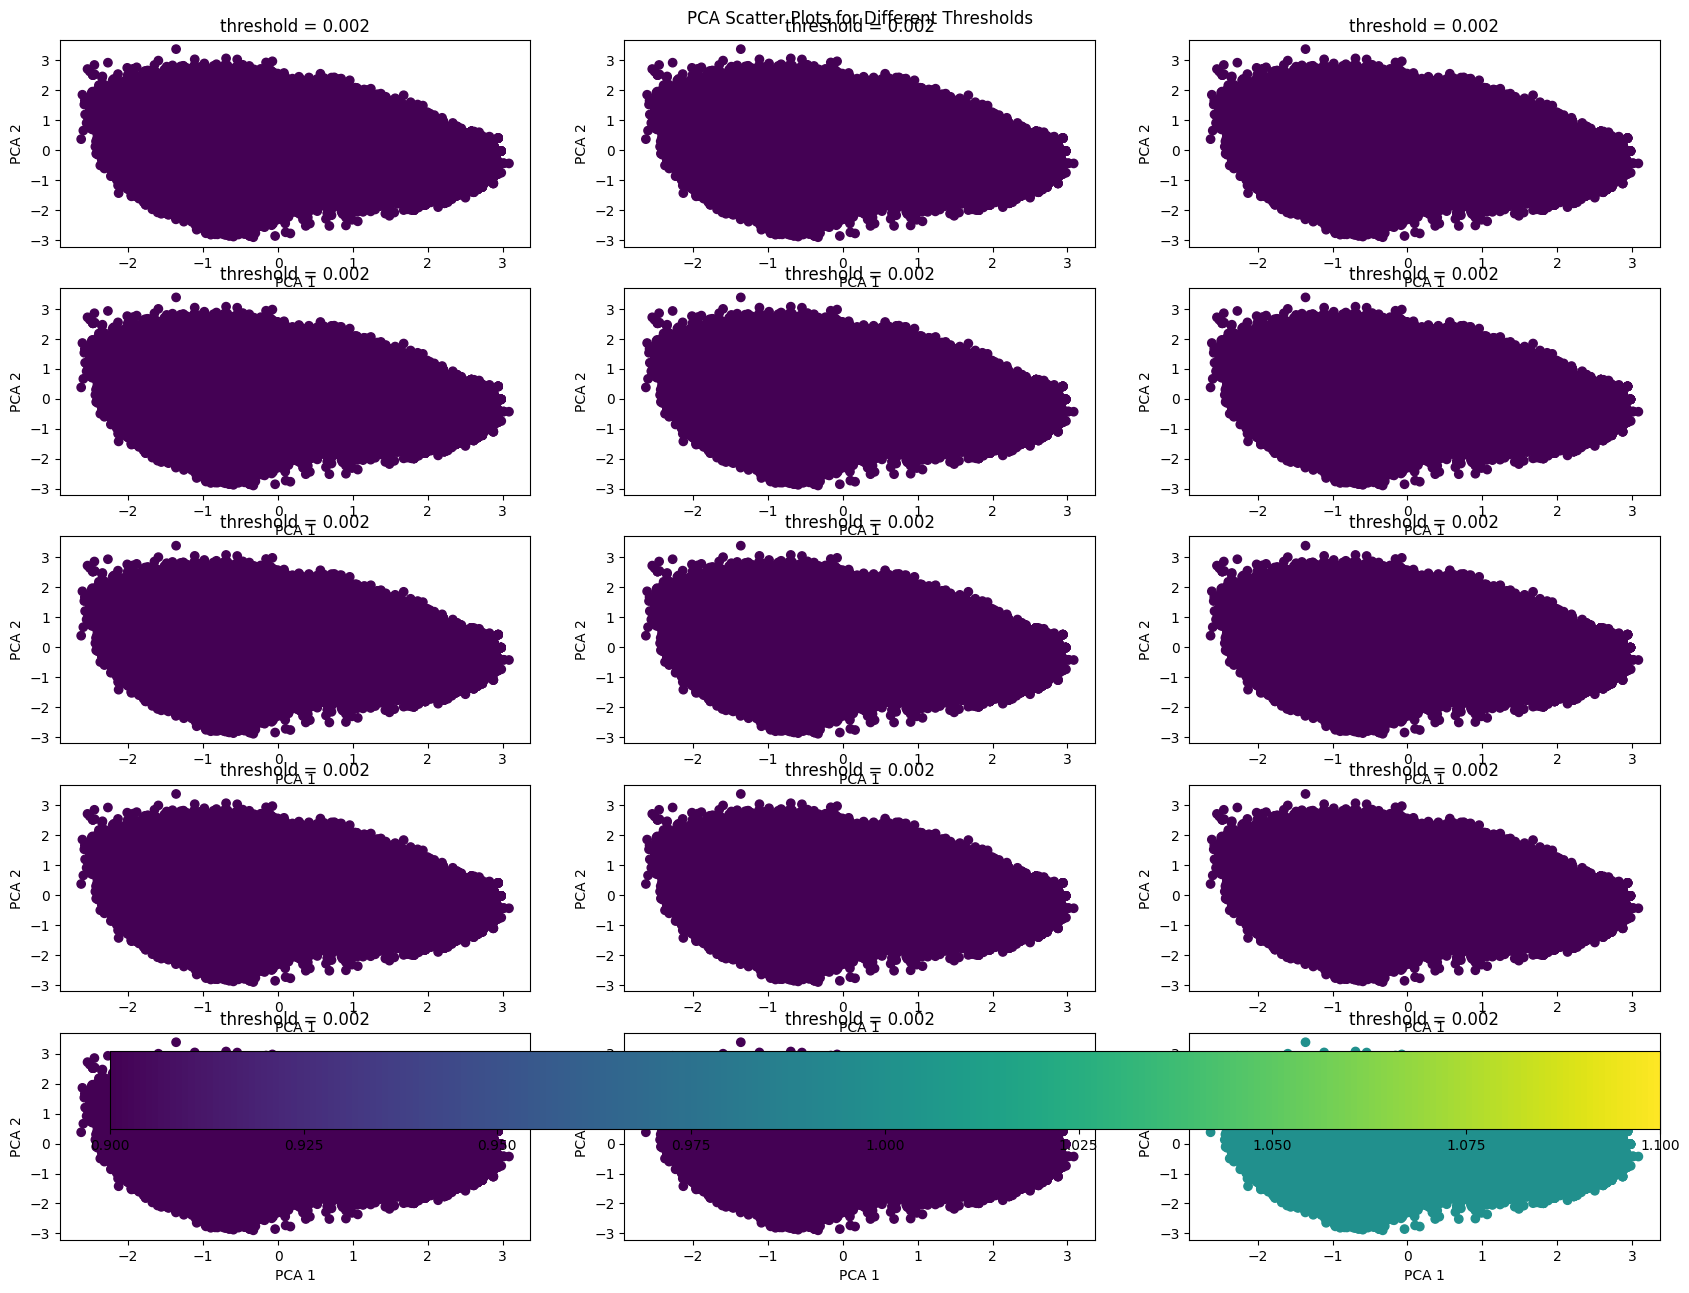

In [18]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
data_pca = pca.fit_transform(test_embeddings_combined)


thresholds = np.linspace(0.001, 0.003, num=15)  # Adjust as needed
fig, axes = plt.subplots(5, 3, figsize=(20, 15))  # Adjust as needed

# Flatten the axes array
axes = axes.flatten()
test_predict = autoencoder.predict(test_embeddings_combined)

mae = get_error_term(test_predict, test_embeddings_combined)
    
for ax, error_thresh in zip(axes, thresholds):
    # Generate the boolean anomaly indicators for the given threshold
    
    error_thresh = 0.002
    anomalies = mae > error_thresh

    # Plot the PCA results
    scatter = ax.scatter(data_pca[:, 0], data_pca[:, 1], c=anomalies, cmap='viridis')
    ax.set_title(f'threshold = {error_thresh}')
    ax.set_xlabel('PCA 1')
    ax.set_ylabel('PCA 2')

# Add a colorbar to the figure
fig.colorbar(scatter, ax=axes.tolist(), orientation='horizontal', pad=0.01)
plt.suptitle('PCA Scatter Plots for Different Thresholds', y=0.92)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.2)
plt.show()


1725/1725 [==============================] - 3s 1ms/step


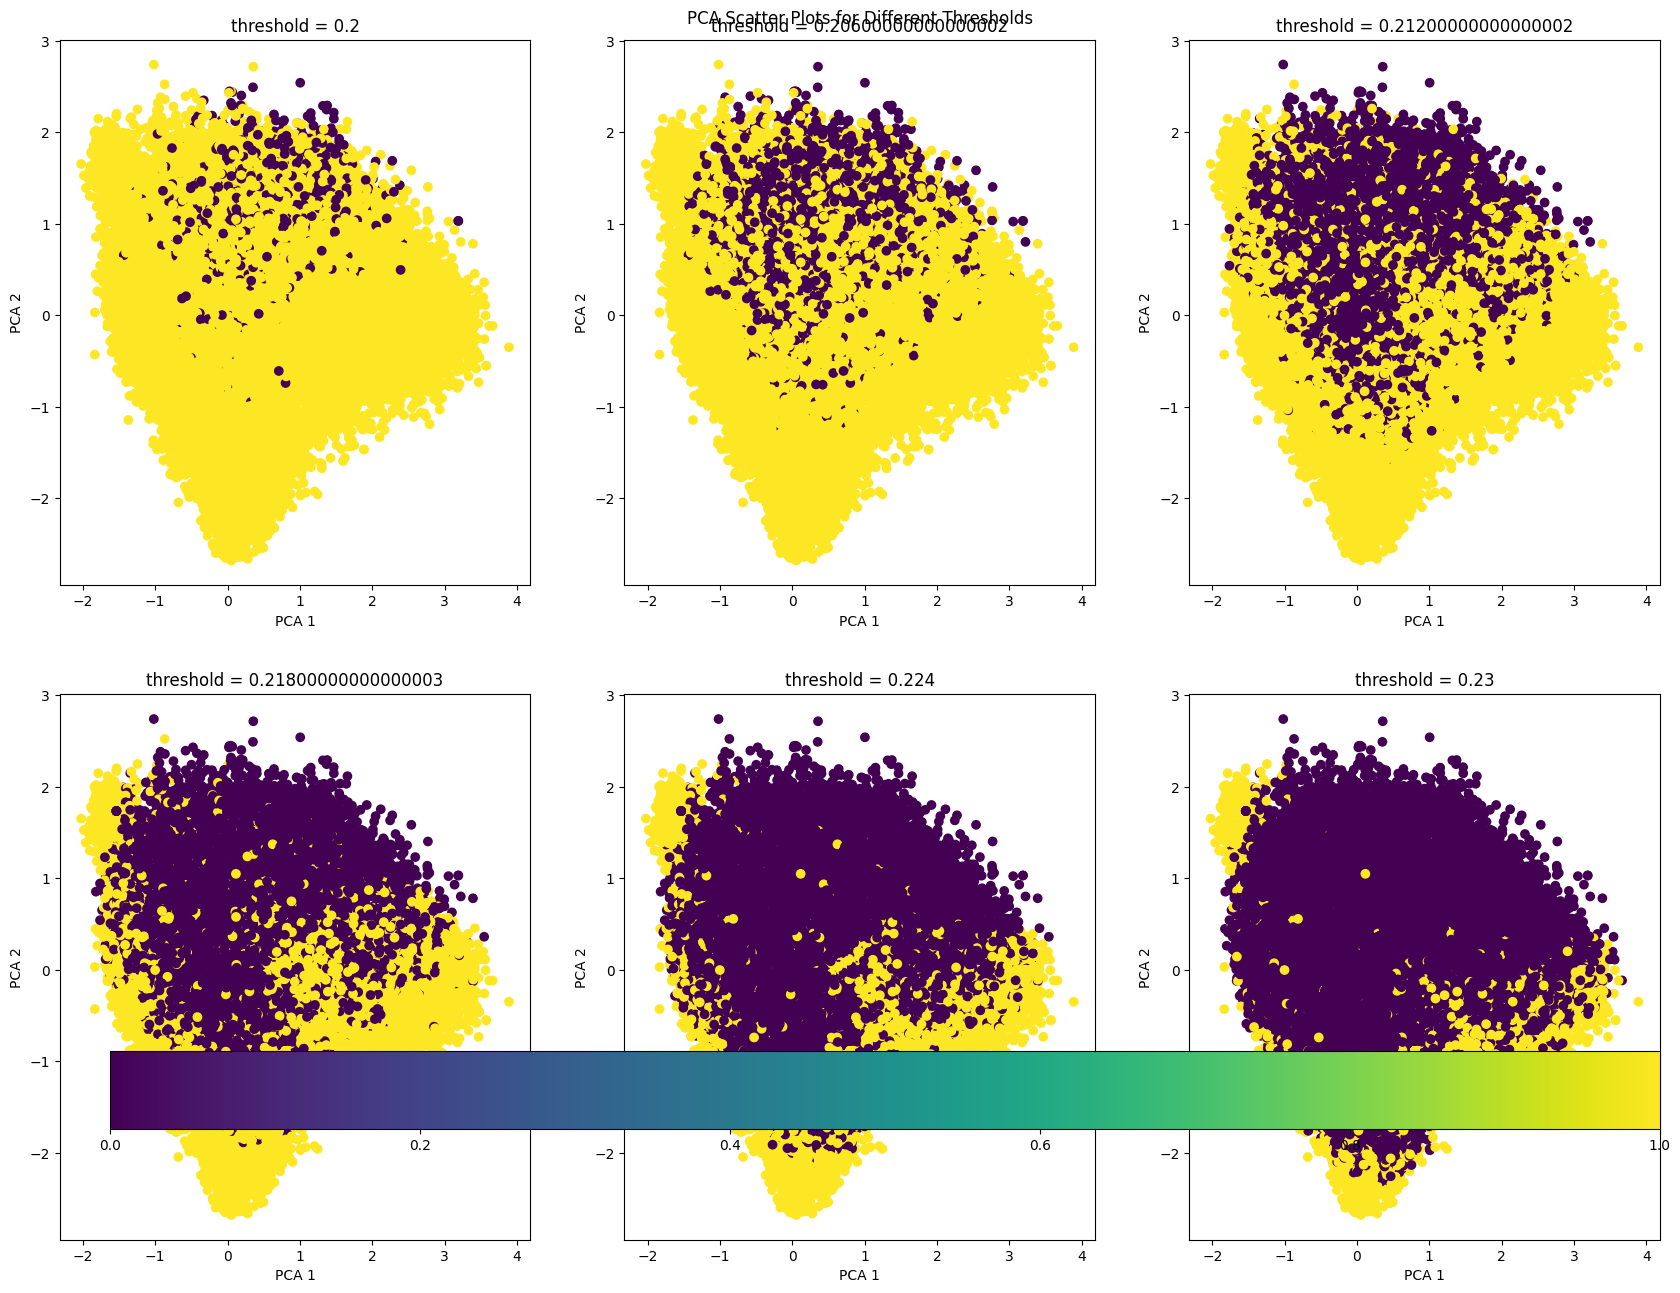

In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
data_pca = pca.fit_transform(test_combine_embeddings)


thresholds = np.linspace(0.20, 0.23, num=6)  # Adjust as needed
fig, axes = plt.subplots(2, 3, figsize=(20, 15))  # Adjust as needed

# Flatten the axes array
axes = axes.flatten()
test_predict = autoencoder.predict(test_combine_embeddings)

mae = get_error_term(test_predict, test_combine_embeddings)
    
for ax, error_thresh in zip(axes, thresholds):
    # Generate the boolean anomaly indicators for the given threshold
    
    anomalies = mae > error_thresh

    # Plot the PCA results
    scatter = ax.scatter(data_pca[:, 0], data_pca[:, 1], c=anomalies, cmap='viridis')
    ax.set_title(f'threshold = {error_thresh}')
    ax.set_xlabel('PCA 1')
    ax.set_ylabel('PCA 2')

# Add a colorbar to the figure
fig.colorbar(scatter, ax=axes.tolist(), orientation='horizontal', pad=0.01)
plt.suptitle('PCA Scatter Plots for Different Thresholds', y=0.92)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.2)
plt.show()


In [56]:
plt.savefig(f'{root_path}/pca_analysis.png', dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

In [11]:
test_combine_embeddings.shape

(55174, 768)

1725/1725 [==============================] - 2s 1ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


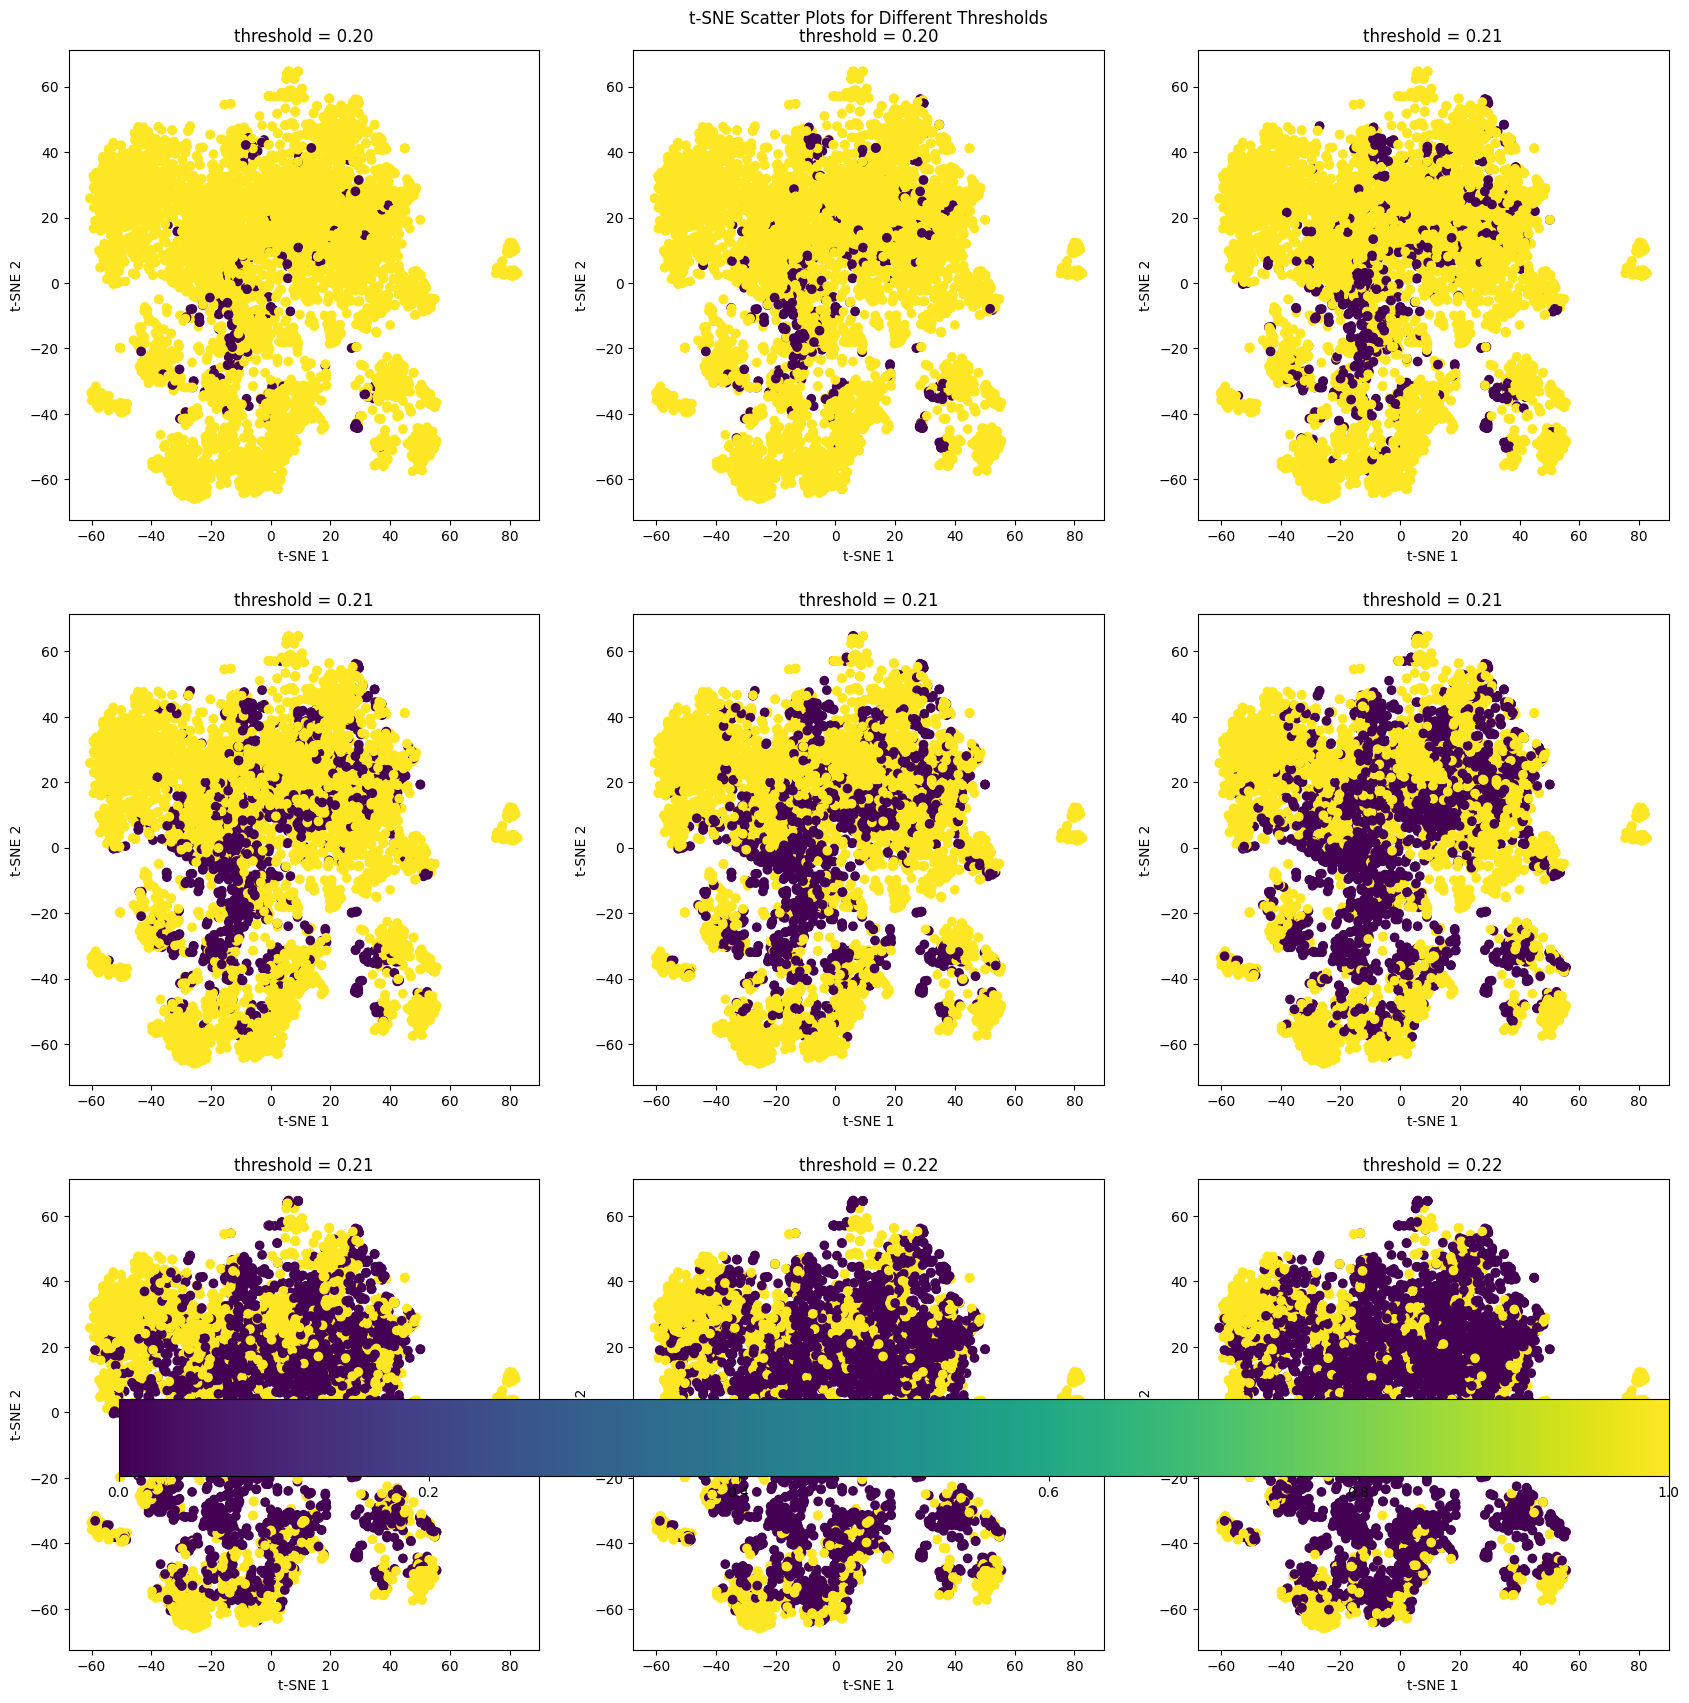

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Define the number of samples for t-SNE
num_samples = 5000  # adjust as needed

# Create a random sample of the embeddings
indices = np.random.choice(range(len(test_combine_embeddings)), size=num_samples, replace=False)
sample_embeddings = test_combine_embeddings[indices]

# Generate predictions from the autoencoder
test_predict = autoencoder.predict(test_combine_embeddings)

# Calculate the Mean Absolute Error (MAE) for the full embeddings
mae_full = get_error_term(test_predict, test_combine_embeddings)

# Select the corresponding subset of MAE values
mae = mae_full[indices]

# Apply t-SNE to the sample embeddings
tsne = TSNE(n_components=2)
data_tsne = tsne.fit_transform(sample_embeddings)

# Define the range and number of thresholds
thresholds = np.linspace(0.20, 0.22, num=9)  # adjust as needed

# Create subplots
fig, axes = plt.subplots(3, 3, figsize=(20, 20))  # adjust as needed

# Flatten the axes array
axes = axes.flatten()

# Loop over each threshold and create a t-SNE plot
for ax, error_thresh in zip(axes, thresholds):
    # Generate the boolean anomaly indicators for the given threshold
    anomalies_sample = mae > error_thresh

    # Create a scatter plot
    scatter = ax.scatter(data_tsne[:, 0], data_tsne[:, 1], c=anomalies_sample, cmap='viridis')
    ax.set_title(f'threshold = {error_thresh:.2f}')
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')

# Add a colorbar to the figure
fig.colorbar(scatter, ax=axes.tolist(), orientation='horizontal', pad=0.01)
plt.suptitle('t-SNE Scatter Plots for Different Thresholds', y=0.92)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.2)
plt.show()


In [19]:
plt.savefig(f'{root_path}/TSNE_analysis.png', dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>